In [111]:
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch

%matplotlib inline
import cv2


def multiply(tup_):
    result = 1
    for i in tup_:
        result += i
    return result


import pytesseract
import warnings

warnings.filterwarnings("ignore")

In [84]:
model = torch.hub.load(
    "ultralytics/yolov5",
    "custom",
    path="../yolov5s_train/weights/best.pt",
    force_reload=True,
)
_ = model.eval()

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /home/user/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-9-24 Python-3.8.13 torch-1.12.1 CUDA:0 (NVIDIA GeForce RTX 2070 SUPER, 8192MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [85]:
img_path = "example.jpg"
save_path = "result.jpg"

img = Image.open(img_path)
img_arr = np.array(img)
result = model(img_arr)

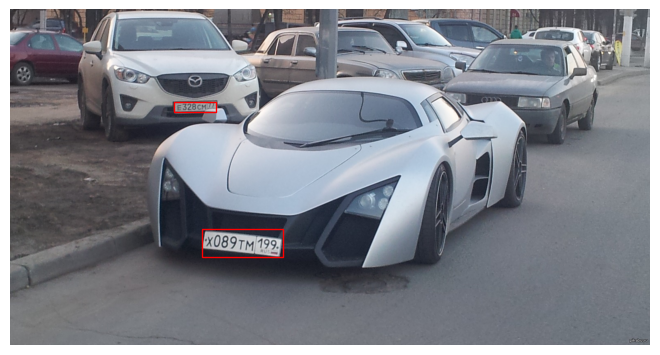

In [86]:
fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
ax.set_axis_off()
fig.add_axes(ax)

res = result.pred[0].detach()
final_res = []
for t in res:
    x1, y1, x2, y2, proba, _ = t.cpu().numpy()
    if proba > 0.6:
        ax.imshow(img)
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor="r", facecolor="none"
        )
        ax.add_patch(rect)
        final_res.append([x1, y1, x2, y2])
_ = fig.savefig(save_path, bbox_inches="tight", pad_inches=0)

In [ ]:
for num_plate in 

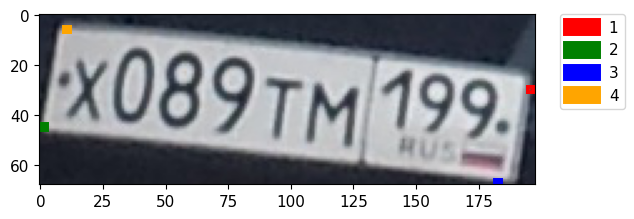

In [87]:
num_plate = final_res[0]

plate_img = img.crop(num_plate)

im_gray = cv2.cvtColor(np.array(plate_img).astype(np.uint8), cv2.COLOR_RGB2GRAY)

th, im_gray_th_otsu = cv2.threshold(im_gray, 128, 255, cv2.THRESH_OTSU)


SCALE_FACTOR = 1

plate_img = plate_img.resize(
    [i * SCALE_FACTOR for i in Image.fromarray(im_gray_th_otsu).size]
)

cnts = cv2.findContours(im_gray_th_otsu, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

sizes_of_0_cnts = [multiply(i.shape) for i in cnts[0]]
cnt = cnts[0][np.argmax(sizes_of_0_cnts)]

xmin, xmax, ymin, ymax = (
    min(cnt[:, 0, 0]),
    max(cnt[:, 0, 0]),
    min(cnt[:, 0, 1]),
    max(cnt[:, 0, 1]),
)

x1, y1 = cnt[np.argmax(cnt[:, 0, 0]), 0, :]
x2, y2 = cnt[np.argmin(cnt[:, 0, 0]), 0, :]
x3, y3 = cnt[np.argmax(cnt[:, 0, 1]), 0, :]
x4, y4 = cnt[np.argmin(cnt[:, 0, 1]), 0, :]

fig, ax = plt.subplots()

ax.imshow(plate_img, cmap="gray")
rect = patches.Rectangle(
    (x1, y1), 1, 1, linewidth=5, edgecolor="r", facecolor="r", label="1"
)
ax.add_patch(rect)
rect = patches.Rectangle(
    (x2, y2), 1, 1, linewidth=5, edgecolor="g", facecolor="g", label="2"
)
ax.add_patch(rect)
rect = patches.Rectangle(
    (x3, y3), 1, 1, linewidth=5, edgecolor="b", facecolor="b", label="3"
)
ax.add_patch(rect)
rect = patches.Rectangle(
    (x4, y4), 1, 1, linewidth=5, edgecolor="orange", facecolor="orange", label="4"
)
ax.add_patch(rect)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.show()

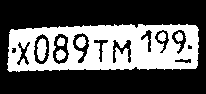

In [109]:
tg_alpha_32 = abs(y3 - y2) / abs(x3 - x2)
tg_alpha_41 = abs(y4 - y1) / abs(x4 - x1)
tg_alpha = (tg_alpha_32 + tg_alpha_41) / 2
new_plate_img = Image.fromarray(im_gray_th_otsu).rotate(
    (np.arctan(tg_alpha) * 180) / np.pi, Image.NEAREST, expand=1
)

new_plate_img

In [122]:
h, w = np.array(new_plate_img).shape

In [140]:
np.argwhere(np.array(new_plate_img).sum(axis=1) != 0).flatten()

array([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71])

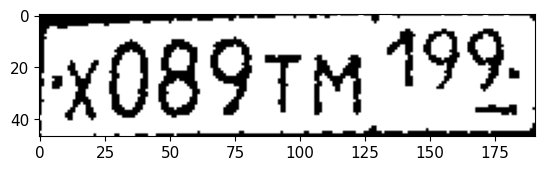

In [148]:
h_idxs = np.argwhere(np.array(new_plate_img).sum(axis=1) != 0).flatten()
w_idxs = np.argwhere(np.array(new_plate_img).sum(axis=0) != 0).flatten()

plate_arr = np.array(new_plate_img)[h_idxs[0] : h_idxs[-1], w_idxs[0] : w_idxs[-1]]

plt.imshow(plate_arr, cmap="gray")

In [149]:
custom_config = r"-c tessedit_char_whitelist=0123456789ABEKMHOPCTYX --oem 3 --psm 6"
pytesseract.image_to_string(plate_arr, config=custom_config)

'MEEE \n\n'